# Spectrum represenation

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import itertools
import logging
import multiprocessing
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library, writer
from ann_solo.config import config

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

# initialize logging
logging.basicConfig(format='%(asctime)s [%(levelname)s/%(processName)s] '
                           '%(module)s.%(funcName)s : %(message)s',
                    level=logging.INFO)

In [4]:
config_filename = '../../bin/ann-solo/iprg2012.ini'
splib_filename = '../../data/interim/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../../data/external/iprg2012/iPRG2012.mgf'
out_dir = '../../data/processed/iprg2012/spectrum_representation'

We consider the following options for the representation of MS2 spectra:

- The number of peaks: ranging from 25 to 150 in steps of 25 for both query spectra and library spectra independently.
- The intensity scaling: either square root scaling or rank scaling.

These representation options are evaluated based on the identification performance in terms of the number of SSMs at a 1% FDR.

Search settings:

- Query file: spectra generated for the [iPRG 2012 study](http://www.mcponline.org/cgi/doi/10.1074/mcp.M113.032813).
- Precursor mass tolerance: 20 ppm
- Fragment mass tolerance: 0.02 Da

In [5]:
def _do_search(settings):
    config.parse(settings)

    spec_lib = spectral_library.SpectralLibrary(
        config.spectral_library_filename)
    identifications = spec_lib.search(config.query_filename)
    writer.write_mztab(identifications, config.out_filename,
                       spec_lib._library_reader)
    spec_lib.shutdown()

    
# Go through all combinations of number of peaks and scaling methods.
for num_peaks_query, num_peaks_library, scaling in itertools.product(
        np.arange(25, 151, 25), np.arange(25, 151, 25), ('sqrt', 'rank')):
    out_filename = os.path.join(out_dir, f'num_peaks_query_{num_peaks_query}-'\
                                         f'num_peaks_library_{num_peaks_library}-'\
                                         f'scaling_{scaling}.mztab')
    if not os.path.isfile(out_filename):
        settings = [f'--config {config_filename}', '--mode bf',
                    f'--max_peaks_used {num_peaks_query}',
                    f'--max_peaks_used_library {num_peaks_library}',
                    f'--scaling {scaling}',
                    splib_filename, mgf_filename, out_filename]
        
        proc = multiprocessing.Process(target=_do_search,
                                       args=(' '.join(settings),))
        proc.start()
        proc.join()

In [6]:
pattern_numpeaks_scaling = re.compile('^num_peaks_query_(\d+)-'
                                      'num_peaks_library_(\d+)-'
                                      'scaling_(rank|sqrt).mztab$')

ssms = {'num_peaks_query': [], 'num_peaks_library': [], 'scaling': [], 'ssms': []}
for filename in os.listdir(out_dir):
    match = pattern_numpeaks_scaling.match(filename)
    if match is not None:
        ssms['num_peaks_query'].append(int(match.group(1)))
        ssms['num_peaks_library'].append(int(match.group(2)))
        ssms['scaling'].append(match.group(3))
        ssms['ssms'].append(
            len(reader.read_mztab_ssms(os.path.join(out_dir, filename))))

ssms = pd.DataFrame(ssms)

/home/wout/.conda/envs/ann_solo/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/wout/.conda/envs/ann_solo/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


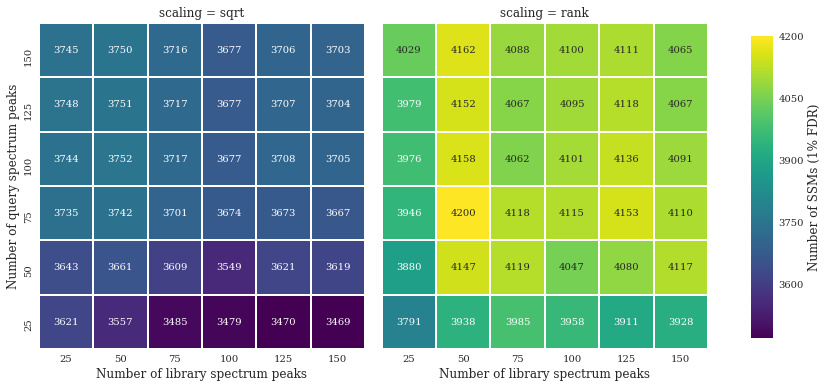

In [7]:
def _plot_heatmap(*args, **kwargs):
    sns.heatmap(kwargs.pop('data').pivot('num_peaks_query', 'num_peaks_library', 'ssms'),
                **kwargs)
    
fg = sns.FacetGrid(ssms, col='scaling', sharex=True, sharey=True, legend_out=True,
                   height=6, aspect=1, gridspec_kws={'wspace': 0.05})
cbar_ax = fg.fig.add_axes([0.95, 0.15, 0.025, 0.7])

fg.map_dataframe(_plot_heatmap, vmin=ssms['ssms'].min(), vmax=ssms['ssms'].max(),
                 cmap='viridis', annot=True, fmt='d', linewidths=1.0,
                 cbar_ax=cbar_ax, square=True)

fg.facet_axis(0, 0).invert_yaxis()
fg.set_axis_labels('Number of library spectrum peaks', 'Number of query spectrum peaks')
cbar_ax.set_ylabel('Number of SSMs (1% FDR)', size='large')

for ax in fg.axes.ravel():
    ax.tick_params(axis='both', which='major', labelsize='medium')
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')
fg.set_titles(size='large')
cbar_ax.tick_params(labelsize='medium')

plt.savefig('preprocess.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
logging.shutdown()